<a href="https://colab.research.google.com/github/dimasprd/College-Final-Project/blob/main/001_AI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install segypy
!pip install catboost
!pip install xgboost
!pip install lightgbm

import segypy
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn import preprocessing
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, max_error
from sklearn.metrics import mean_squared_error, mean_pinball_loss

import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 200
plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# load the dataset

dataset_F032 = pd.read_excel(
    '/content/drive/My Drive/Final Project/Well-F032.xlsx'
)
dataset_F021 = pd.read_excel(
    '/content/drive/My Drive/Final Project/Well-F021.xlsx'
)
dataset_F061 = pd.read_excel(
    '/content/drive/My Drive/Final Project/Well-F061.xlsx'
)

In [29]:
# set the data range

data_F032 = dataset_F032[
    dataset_F032[dataset_F032['twt']==430.076].index[0] :
    dataset_F032[dataset_F032['twt']==926.986].index[0]
]

data_F021 = dataset_F021[
    dataset_F021[dataset_F021['twt']==481.11].index[0] :
    dataset_F021[dataset_F021['twt']==1103.946].index[0]
]

data_F061 = dataset_F061[
    dataset_F061[dataset_F061['twt']==649.854].index[0] :
    dataset_F061[dataset_F061['twt']==1087.04].index[0]
]

In [30]:
def normalize(data, data_norm=None, normalize=True):
    '''
    to normalize data
    
    params:
    
    data: data to normalize. should in 2d array
    data_norm: data to unnormalize.
    normalize: (True, False). if True, data will be normalize and "data_norm"
    param is unnecessary if False, "data_norm" is the data to be normalize
    and "data" param is necessary
    '''
    min_val = min(data.values.flatten())
    max_val = max(data.values.flatten())
    
    if normalize:
        return (data - min_val)/(max_val - min_val)
    else:
        return data_norm*(max_val - min_val) + min_val

    
def scaling_col_values(data, min_val=None, max_val=None):
    '''
    function to normalize certain column values in DataFrame
    '''
    return (data - min_val)/(max_val - min_val)


def scaling_df_values(df):
    '''
    function to normalize all columns values in DataFrame
    '''
    df_scaled = df.copy()
    for i in range(len(df_scaled.columns)):
        min_val = min(df_scaled[df_scaled.columns[i]])
        max_val = max(df_scaled[df_scaled.columns[i]])
        df_scaled[df_scaled.columns[i]] = scaling_col_values(
            df_scaled[df_scaled.columns[i]],
            min_val=min_val, max_val=max_val
        )
    return df_scaled


def absolute_error(actual_data, prediction_data):
    '''
    function to calculate absolute error
    '''
    return abs(actual_data - prediction_data)


def load_data(data):
    '''
    function to load seismic data
    '''
    read = segypy.readSegy(data)
    return read[0]


def filter(df, order=5, cutoff=10, fs=1000/2):
    df_filt = df.apply(
      lambda data: filtfilt(
          butter(order, (cutoff / (0.5 * fs)), btype='low', analog=False)[0], 
          butter(order, (cutoff / (0.5 * fs)), btype='low', analog=False)[1],
          data
          )
      )
    return df_filt

In [31]:
# transform pwave respect to impedance

lf_ai_032 = data_F032['ai_model']
lf_ai_021 = data_F021['ai_model']
lf_ai_061 = data_F061['ai_model']

lf_pw_032 = data_F032['pw_model']
lf_pw_021 = data_F021['pw_model']
lf_pw_061 = data_F061['pw_model']

lf_pw_032_norm = normalize(lf_pw_032)
lf_pw_021_norm = normalize(lf_pw_021)
lf_pw_061_norm = normalize(lf_pw_061)

lf_pw_032_ai = normalize(
    lf_ai_032, data_norm = lf_pw_032_norm, normalize=False
)
lf_pw_021_ai = normalize(
    lf_ai_021, data_norm = lf_pw_021_norm, normalize=False
)
lf_pw_061_ai = normalize(
    lf_ai_032, data_norm = lf_pw_061_norm, normalize=False
)

In [32]:
# assign pw2ai to a new column 

data_F032['pw2ai_model'] = lf_pw_032_ai
data_F021['pw2ai_model'] = lf_pw_021_ai
data_F061['pw2ai_model'] = lf_pw_061_ai

In [33]:
# set features and target

features = [
            'pw_model', 'amp_env', 'amp_wgh_cos_phase',
            'int_abs_amp', 'deriv_inst_amp', 'quad'
]
target = ['true_ai']

In [34]:
training_wells = [data_F032, data_F021]
testing_wells = [data_F061]

training_wells_comp = pd.concat(training_wells)
training_wells_comp = training_wells_comp.sample(frac=1)

testing_well_comp = testing_wells[0]

X_train = training_wells_comp[features]
y_train = training_wells_comp[target]

X_test = testing_well_comp[features]
y_test = testing_well_comp[target]

In [35]:
# scale the data

scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler_x.fit(X_train)
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(y_train)
y_train_scaled = scaler_y.transform(y_train) 
y_test_scaled = scaler_y.transform(y_test)

In [36]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
y_train_scaled = pd.DataFrame(y_train_scaled, columns = y_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, columns = y_test.columns)

# Gradient Boosting

In [37]:
model_gb = GradientBoostingRegressor(
    learning_rate=0.2,
    max_depth=9,
    min_samples_leaf=2,
    min_samples_split=7,
    n_estimators=500,
).fit(X_train_scaled, y_train_scaled)

# prediction
pred_gb_scaled = model_gb.predict(X_test_scaled)

# inverse transform
pred_gb_scaled = pred_gb_scaled.reshape((pred_gb_scaled.shape[0], 1))
pred_gb = scaler_y.inverse_transform(pred_gb_scaled)
pred_gb = np.array(pred_gb)

# save prediction result
np.save(
    '/content/drive/My Drive/Final Project/Prediction Results/pred_gb',
    pred_gb
)

# create to DataFrame
pred_gb_df = pd.DataFrame({'GB prediction': pred_gb.flatten()})

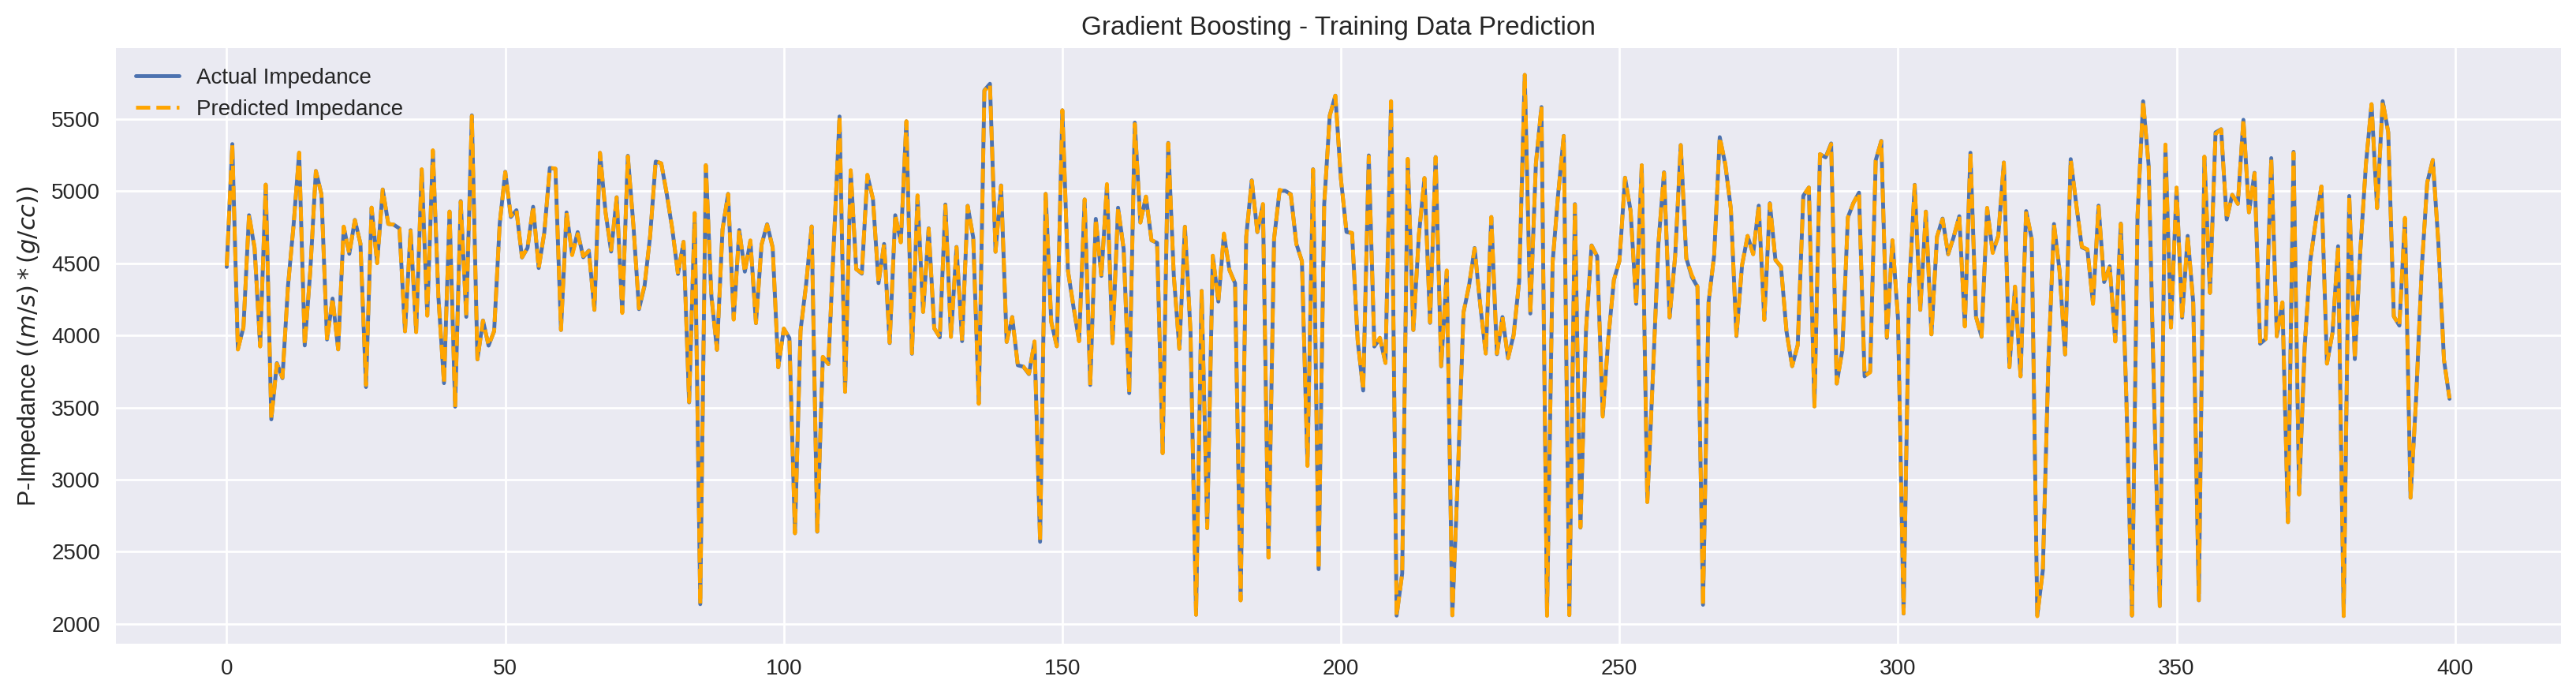

In [38]:
# prediction on training data
pred_train_gb_scaled = model_gb.predict(X_train_scaled)
temp1 = pred_train_gb_scaled.reshape((pred_train_gb_scaled.shape[0], 1))
pred_train_gb = scaler_y.inverse_transform(temp1)
pred_train_gb = np.array(pred_train_gb)

plt.figure(figsize = (20,5))
plt.plot(
    y_train.values[100:500], label = "Actual Impedance"
)
plt.plot(
    pred_train_gb[100:500], "--", color = "orange",
    label = "Predicted Impedance"
)

plt.title('Gradient Boosting - Training Data Prediction')
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()
plt.show()

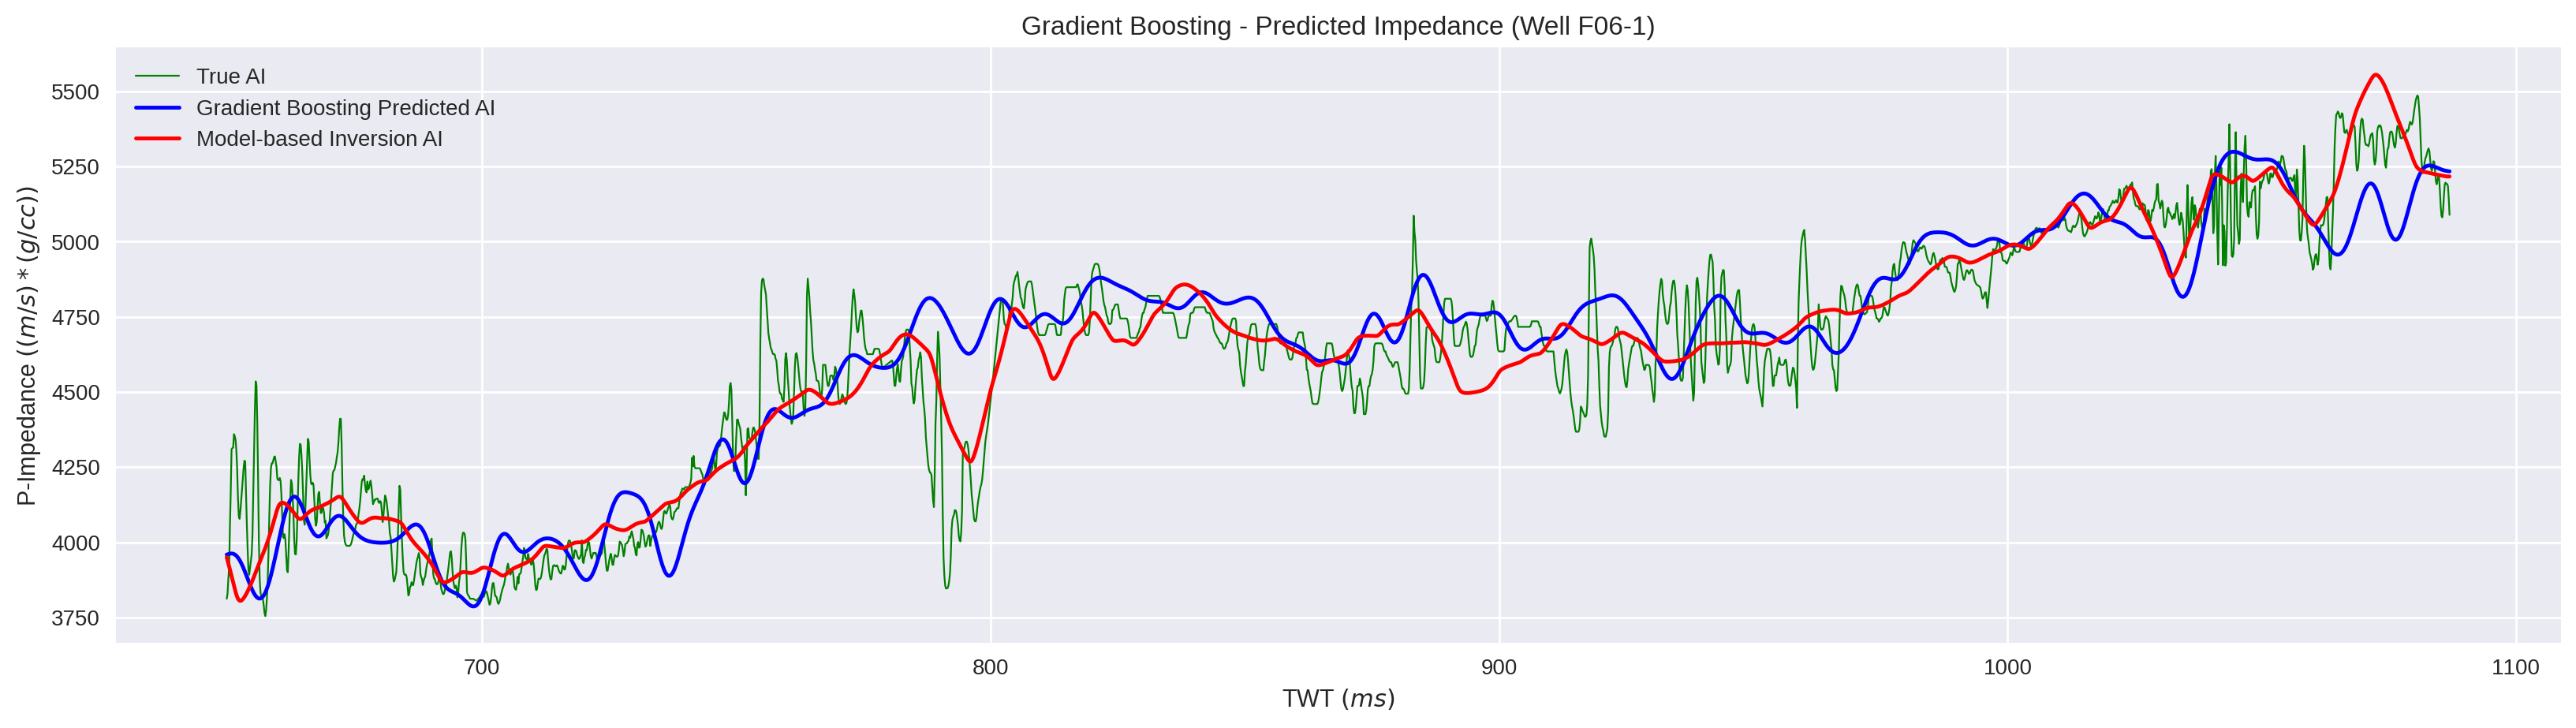

In [39]:
# prediction on test data
plt.figure(figsize = (20,5))
plt.plot(
    data_F061['twt'], y_test, color='g',
    linewidth=0.8, label = "True AI"
)
plt.plot(
    data_F061['twt'], filter(pred_gb_df), "-", color = "b",
    label = "Gradient Boosting Predicted AI"
)
plt.plot(
    data_F061['twt'], data_F061['mbi'], color='red',
    label = "Model-based Inversion AI"
)

plt.title('Gradient Boosting - Predicted Impedance (Well F06-1)')
plt.xlabel("TWT $(ms)$")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()

plt.show()

In [40]:
metrics_df = pd.DataFrame({
    "MAE" : [
             mean_absolute_error(y_test, data_F061['mbi']),
             mean_absolute_error(y_test, pred_gb)
    ],
    "R2"  : [
             r2_score(y_test, data_F061['mbi']),
             r2_score(y_test, pred_gb)
    ],
    "ME"  : [
             max_error(y_test, data_F061['mbi']),
             max_error(y_test, pred_gb)
    ],
    "MSE" : [
             mean_squared_error(y_test, data_F061['mbi'], squared=True),
             mean_squared_error(y_test, pred_gb, squared=True)
    ],
    "RMSE" : [
              mean_squared_error(y_test, data_F061['mbi'], squared=False),
              mean_squared_error(y_test, pred_gb, squared=False)
    ]
})

metrics_df.index = ['Model-based', 'Gradient-Boosting']
metrics_df

MAE        R2          ME           MSE        RMSE
Model-based         98.06638  0.894347  635.667500  17531.451699  132.406388
Gradient-Boosting  135.11112  0.799998  960.591767  33187.305263  182.173833

# Extreme Gradient Boosting (XGBoost)

In [41]:
# Training
model_xgb = XGBRegressor(
    n_estimators = 500,
    max_depth = 9,
    n_jobs = -1,
    learning_rate = 0.2,
    random_state = 0
).fit(X_train_scaled, y_train_scaled)

# Prediction
pred_xgb_scaled = model_xgb.predict(X_test_scaled)

# Inverse transform
temp1 = pred_xgb_scaled.reshape((pred_xgb_scaled.shape[0], 1))
pred_xgb = scaler_y.inverse_transform(temp1)
pred_xgb = np.array(pred_xgb)

# save prediction result
np.save(
    '/content/drive/My Drive/Final Project/Prediction Results/pred_xgb',
    pred_xgb
)

# create to DataFrame
pred_xgb_df = pd.DataFrame({'XGB prediction': pred_xgb.flatten()})

[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


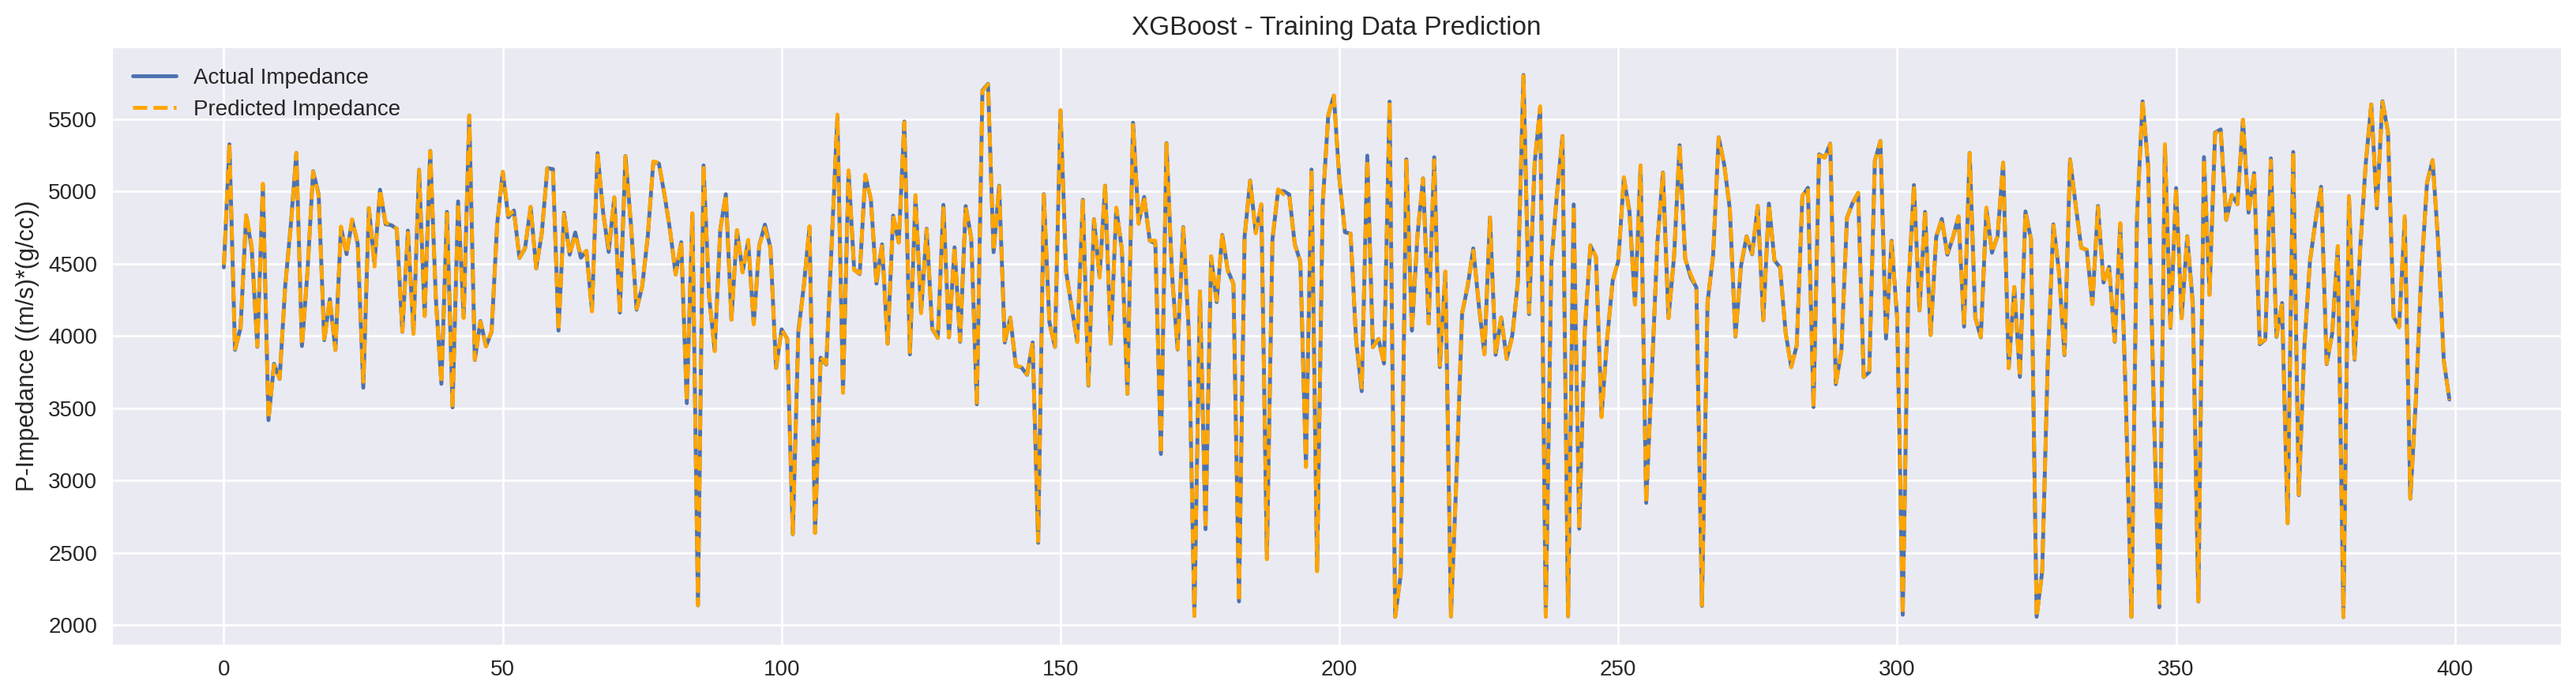

In [42]:
# Training data
pred_train_xgb_scaled = model_xgb.predict(X_train_scaled)
temp1 = pred_train_xgb_scaled.reshape((pred_train_xgb_scaled.shape[0], 1))
pred_train_xgb = scaler_y.inverse_transform(temp1)
pred_train_xgb = np.array(pred_train_xgb)

plt.figure(figsize = (20,5))
plt.plot(y_train.values[100:500], label = "Actual Impedance")
plt.plot(
    pred_train_xgb[100:500], "--", color = "orange",
    label = "Predicted Impedance"
)


plt.title('XGBoost - Training Data Prediction')
plt.ylabel("P-Impedance ((m/s)*(g/cc))")
plt.legend()
plt.show()

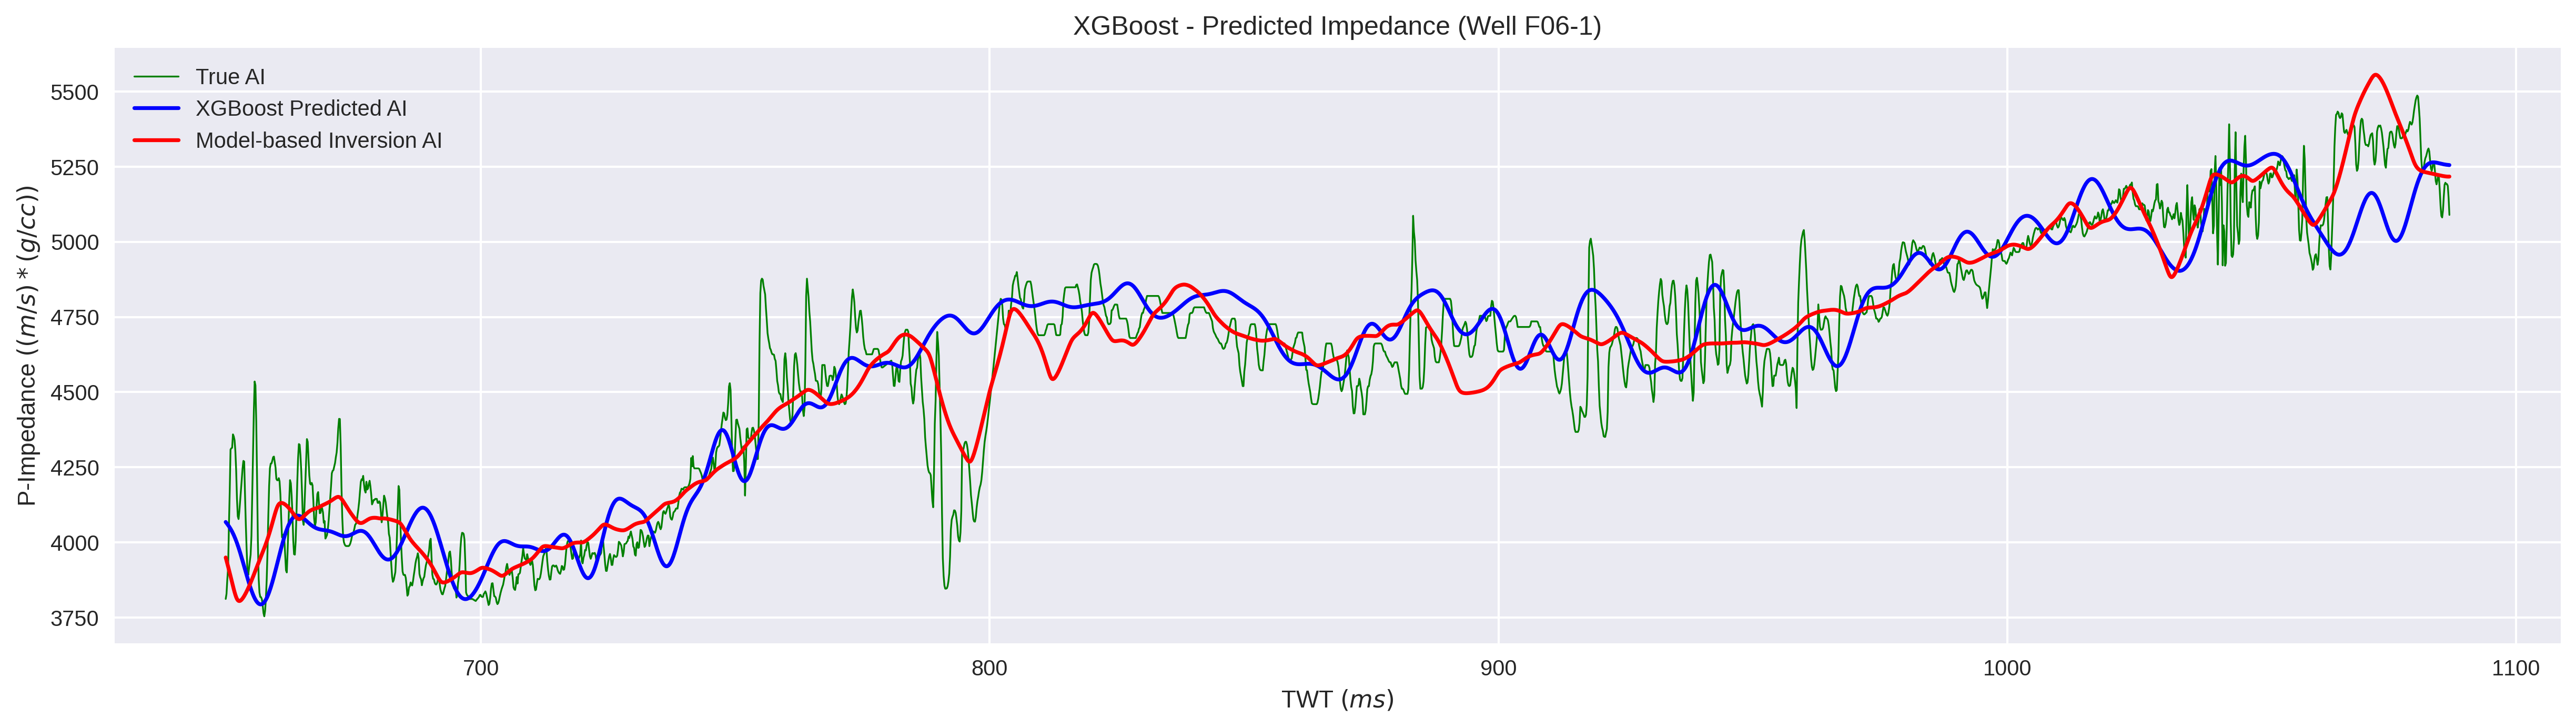

In [43]:
# Testing data
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize = (20,5))
plt.plot(
    data_F061['twt'], y_test, color='g',
    linewidth=0.8, label = "True AI"
)
plt.plot(
    data_F061['twt'], filter(pred_xgb_df), "-",
    color = "b", label = "XGBoost Predicted AI"
)
plt.plot(
    data_F061['twt'], data_F061['mbi'],
    color='red', label = "Model-based Inversion AI"
)

plt.title('XGBoost - Predicted Impedance (Well F06-1)')
plt.xlabel("TWT $(ms)$")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()

plt.show()

In [44]:
metrics_df = pd.DataFrame({
    "MAE" : [
             mean_absolute_error(y_test, data_F061['mbi']),
             mean_absolute_error(y_test, pred_xgb)
    ],
    "R2"  : [
             r2_score(y_test, data_F061['mbi']),
             r2_score(y_test, pred_xgb)
    ],
    "ME"  : [
             max_error(y_test, data_F061['mbi']),
             max_error(y_test, pred_xgb)
    ],
    "MSE" : [
             mean_squared_error(y_test, data_F061['mbi'], squared=True),
             mean_squared_error(y_test, pred_xgb, squared=True)
    ],
    "RMSE" : [
              mean_squared_error(y_test, data_F061['mbi'], squared=False),
              mean_squared_error(y_test, pred_xgb, squared=False)
    ]
})

metrics_df.index = ['Model-based', 'XGBoost']
metrics_df

MAE        R2          ME           MSE        RMSE
Model-based   98.066380  0.894347  635.667500  17531.451699  132.406388
XGBoost      131.579507  0.803193  882.959727  32657.120422  180.712812

# Category Boosting (CatBoost)

In [45]:
train_dataset = cb.Pool(X_train_scaled, y_train_scaled) 
test_dataset = cb.Pool(X_test_scaled, y_test_scaled)

model = cb.CatBoostRegressor(loss_function="RMSE")
grid = {'iterations': [200, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'depth': [6, 8, 9, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
# model.grid_search(grid, train_dataset)

In [ ]:
# Training
model_cb = cb.CatBoostRegressor(
    loss_function="RMSE",
    iterations= 500,
    learning_rate= 0.2,
    l2_leaf_reg= 0.2,
    depth=10
).fit(train_dataset)

# Prediction
pred_cb_scaled = model_cb.predict(X_test_scaled)

# Inverse transform
temp1 = pred_cb_scaled.reshape((pred_cb_scaled.shape[0], 1))
pred_cb = scaler_y.inverse_transform(temp1)
pred_cb = np.array(pred_cb)

# save prediction result
np.save(
    '/content/drive/My Drive/Final Project/Prediction Results/pred_cb',
    pred_cb
)

# create to DataFrame
pred_cb_df = pd.DataFrame({'CB prediction': pred_cb.flatten()})

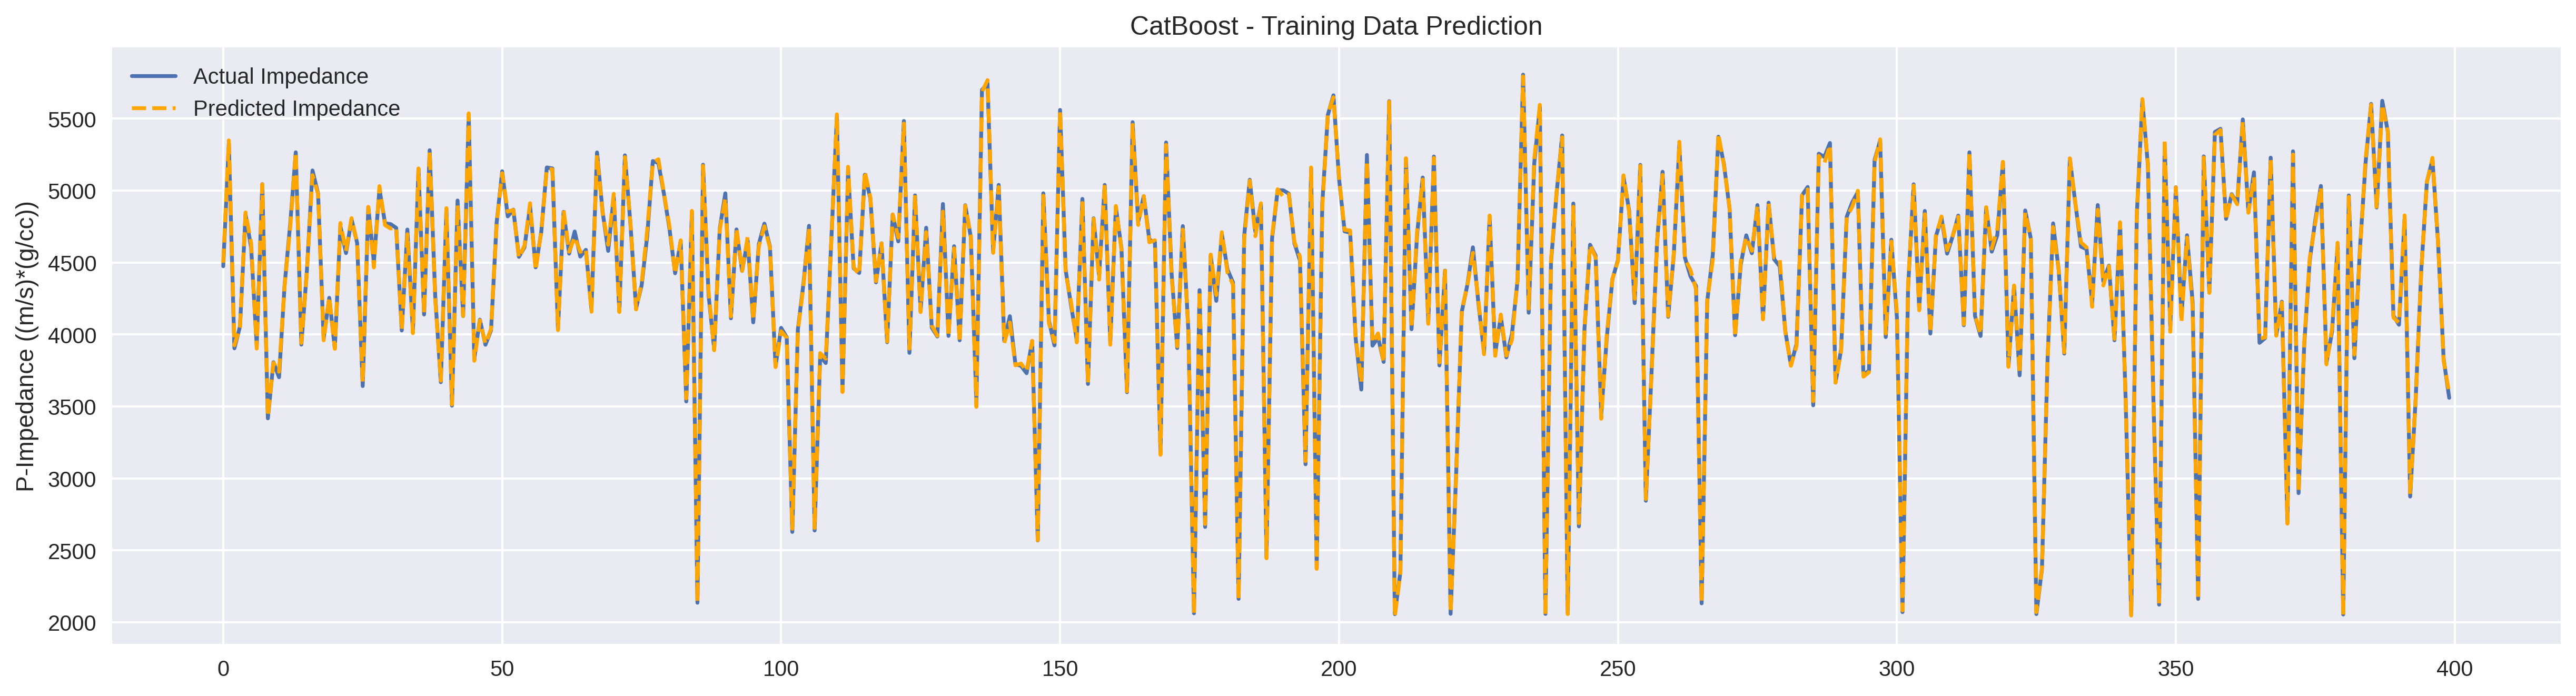

In [47]:
# Training data
pred_train_cb_scaled = model_cb.predict(X_train_scaled)
temp1 = pred_train_cb_scaled.reshape((pred_train_cb_scaled.shape[0], 1))
pred_train_cb = scaler_y.inverse_transform(temp1)
pred_train_cb = np.array(pred_train_cb)

plt.figure(figsize = (20,5))
plt.plot(y_train.values[100:500], label = "Actual Impedance")
plt.plot(
    pred_train_cb[100:500], "--", color = "orange",
    label = "Predicted Impedance"
)

plt.title('CatBoost - Training Data Prediction')
plt.ylabel("P-Impedance ((m/s)*(g/cc))")
plt.legend()
plt.show()

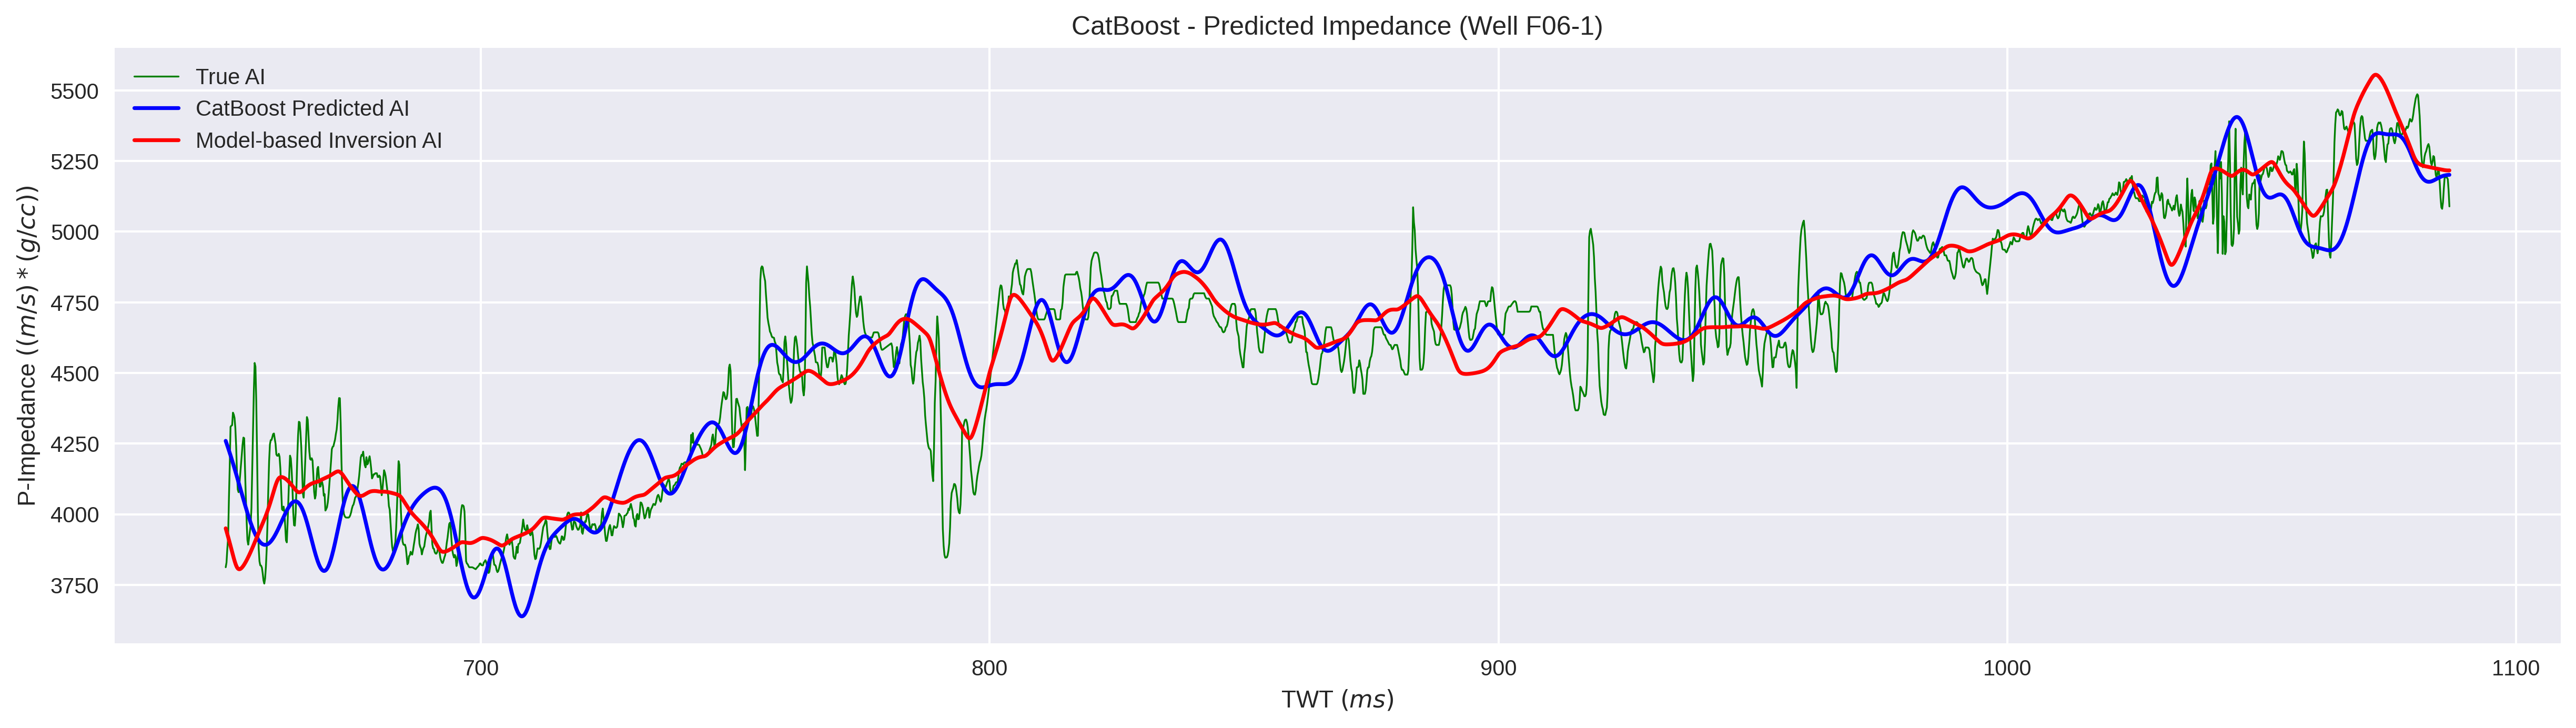

In [48]:
# Testing data
plt.figure(figsize = (20,5))
plt.plot(
    data_F061['twt'], y_test, color='g',
    linewidth=0.8, label = "True AI"
)
plt.plot(
    data_F061['twt'], filter(pred_cb_df),
     "-", color = "b", label = "CatBoost Predicted AI"
)
plt.plot(
    data_F061['twt'], data_F061['mbi'], 
    color='red', label = "Model-based Inversion AI"
)

plt.title('CatBoost - Predicted Impedance (Well F06-1)')
plt.xlabel("TWT $(ms)$")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()

plt.show()

In [49]:
metrics_df = pd.DataFrame({
    "MAE" : [mean_absolute_error(y_test, data_F061['mbi']), mean_absolute_error(y_test, pred_cb)],
    "R2"  : [r2_score(y_test, data_F061['mbi']), r2_score(y_test, pred_cb)],
    "ME"  : [max_error(y_test, data_F061['mbi']), max_error(y_test, pred_cb)],
    "MSE" : [mean_squared_error(y_test, data_F061['mbi'], squared=True), mean_squared_error(y_test, pred_cb, squared=True)],
    "RMSE" : [mean_squared_error(y_test, data_F061['mbi'], squared=False), mean_squared_error(y_test, pred_cb, squared=False)]
})

metrics_df.index = ['Model-based', 'CatBoost']
metrics_df

MAE        R2           ME           MSE        RMSE
Model-based   98.066380  0.894347   635.667500  17531.451699  132.406388
CatBoost     144.392687  0.780470  1037.866914  36427.661740  190.860320

# Light Gradient Boosting Machine (LightGBM)

In [ ]:
# defining parameters 
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

# training
model_lgbm = lgb.LGBMRegressor(**hyper_params)
model_lgbm.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_test_scaled, y_test_scaled)],
    eval_metric='l1',
    early_stopping_rounds=1000
)

# prediction
pred_lgbm_scaled = model_lgbm.predict(
    X_test_scaled, num_iteration=model_lgbm.best_iteration_
)

# inverse transform
temp1 = pred_lgbm_scaled.reshape((pred_lgbm_scaled.shape[0], 1))
pred_lgbm = scaler_y.inverse_transform(temp1)
pred_lgbm = np.array(pred_lgbm)

# save prediction result
np.save(
    '/content/drive/My Drive/Final Project/Prediction Results/pred_lgbm',
    pred_lgbm
)

# create a DataFrame
pred_lgbm_df = pd.DataFrame({'LGBM prediction': pred_lgbm.flatten()})

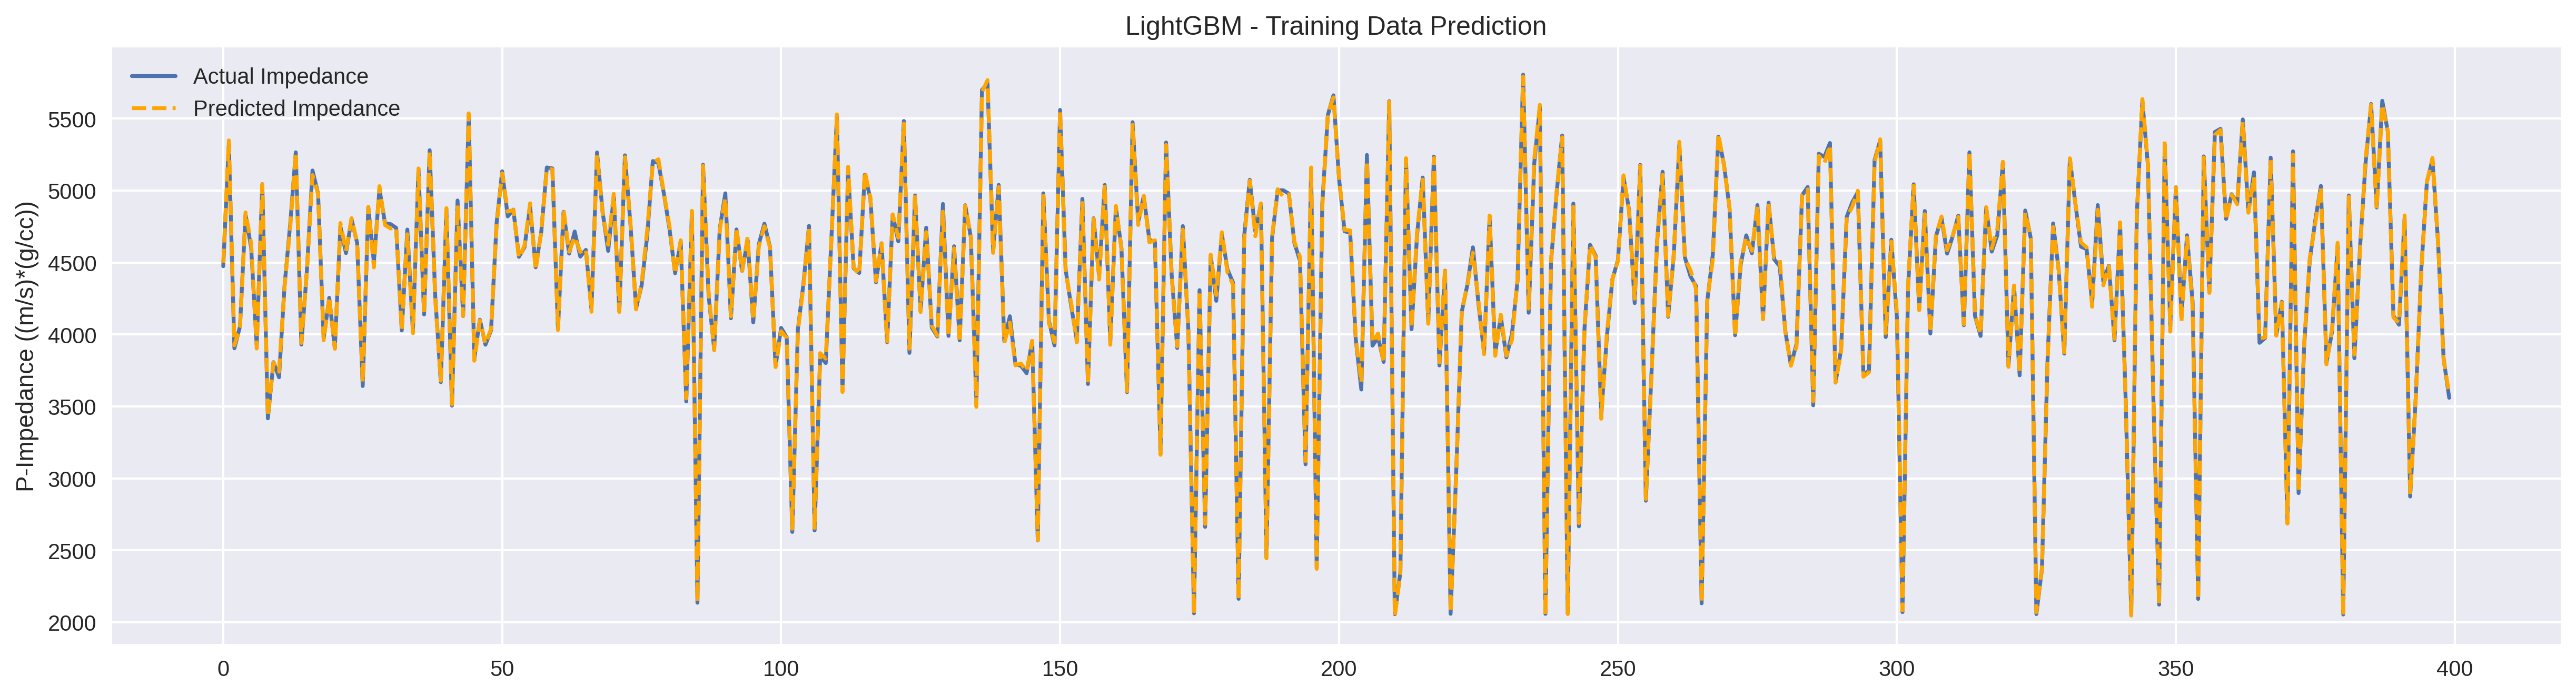

In [51]:
# Training data
pred_train_lgbm_scaled = model_lgbm.predict(X_train_scaled)
temp1 = pred_train_lgbm_scaled.reshape((pred_train_lgbm_scaled.shape[0], 1))
pred_train_lgbm = scaler_y.inverse_transform(temp1)
pred_train_lgbm = np.array(pred_train_lgbm)

plt.figure(figsize = (20,5))
plt.plot(y_train.values[100:500], label = "Actual Impedance")
plt.plot(pred_train_cb[100:500], "--", color = "orange", label = "Predicted Impedance")


plt.title('LightGBM - Training Data Prediction')
plt.ylabel("P-Impedance ((m/s)*(g/cc))")
plt.legend()
plt.show()

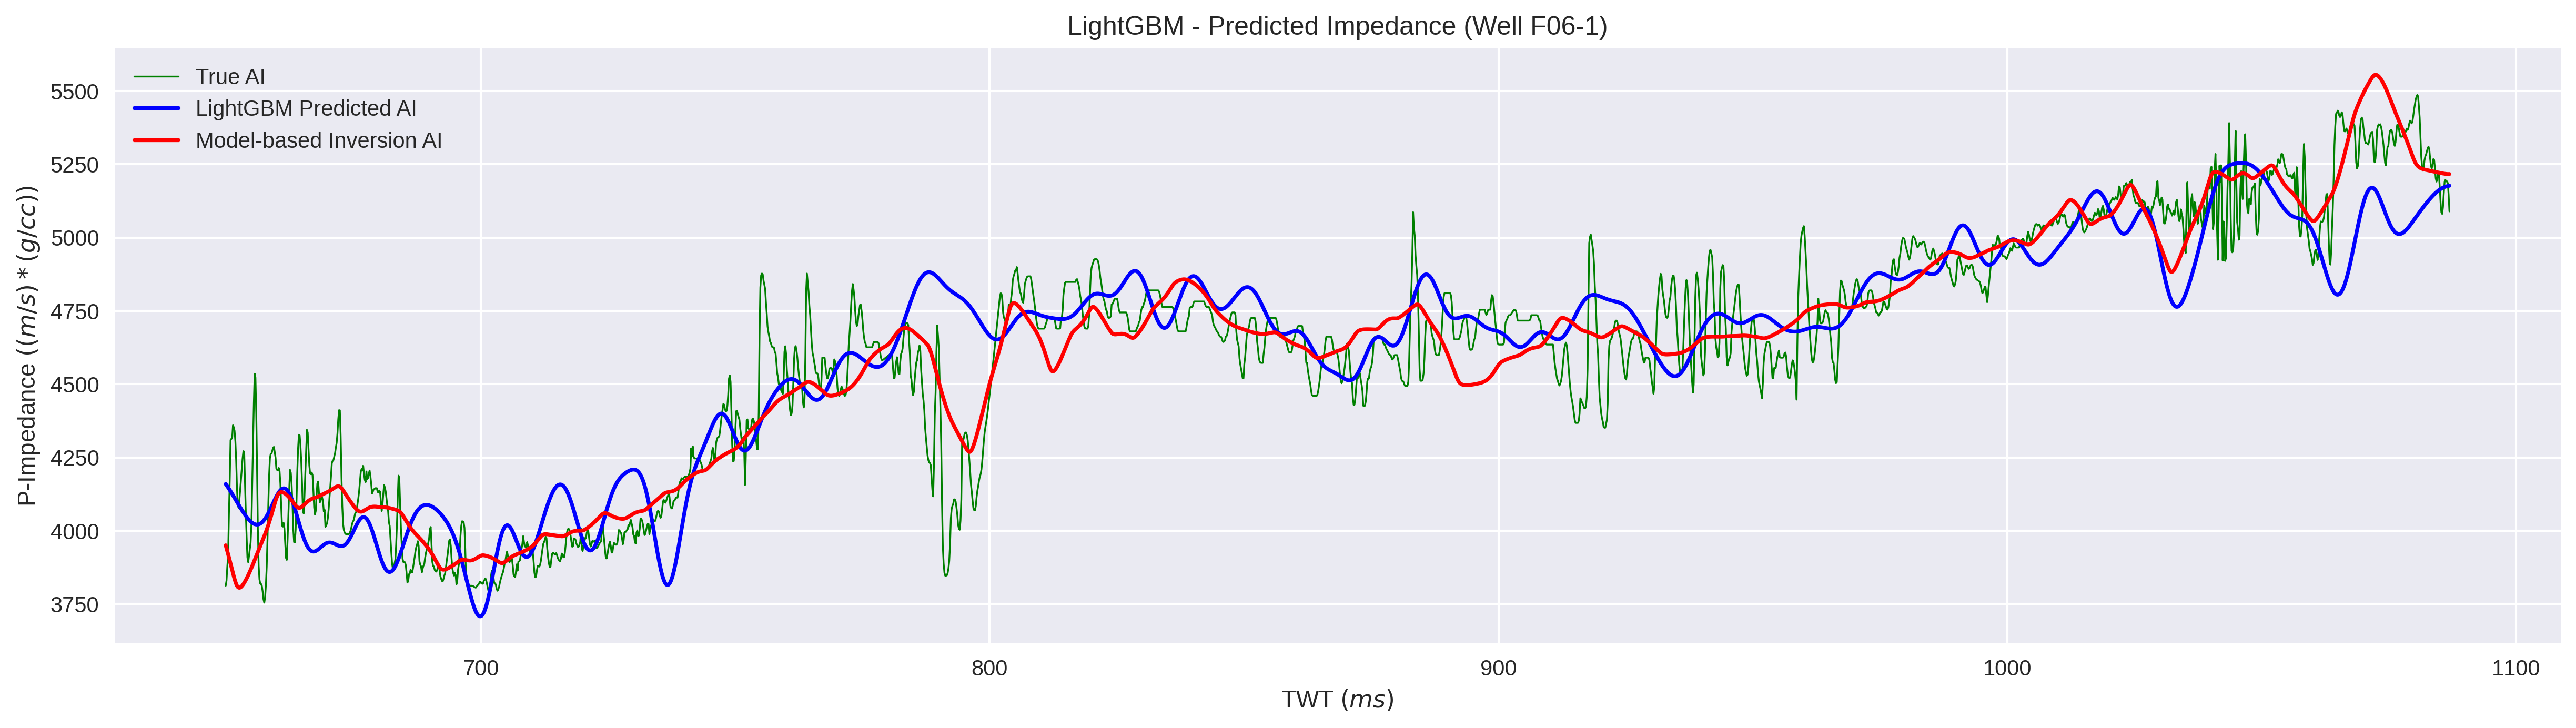

In [53]:
# Testing data
plt.figure(figsize = (20,5))
plt.plot(data_F061['twt'], y_test, color='g', linewidth=0.8, label = "True AI")
plt.plot(data_F061['twt'], filter(pred_lgbm_df), "-", color = "b", label = "LightGBM Predicted AI")
plt.plot(data_F061['twt'], data_F061['mbi'], color='red', label = "Model-based Inversion AI")

plt.title('LightGBM - Predicted Impedance (Well F06-1)')
plt.xlabel("TWT $(ms)$")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()

plt.show()

# Long-Short Term Memory (LSTM)